In [1]:
import numpy as np

In [66]:
def updateA(X, S):
    
    n, l = X.shape
    I = np.eye(n)
    regularizer = 0.00001
    
    XST = X @ S.T
    SST = S @ S.T
    F1 = (XST + regularizer*I)
    F2 = (SST + regularizer*I)
    F2_inv = np.linalg.inv(F2)
    A = F1 @ F2_inv
    return A

In [67]:
def updateS(X, A, m, O):
    n, l = X.shape
    #O = np.ones((n, 1))
    ATA = A.T @ A
    ATX = A.T @ X
    F1 = (ATA + O @ O.T) + 0.00001*np.eye(n)
    F1_inv = np.linalg.inv(F1)
    F2 = (O @ m + A.T @ X)
    S = F1_inv @ F2
    return S

In [68]:
def objective(X, A, S, m, O):
    return np.linalg.norm(X-(A@S))**2 + np.linalg.norm(m-np.sum(np.dot(O.T, S), axis=0))**2

In [76]:
def project(A, gamma1, gamma2):
    n, _ = A.shape
    for i in range(n):
        for j in range(n):
            if i!=j:
                if A[i][j] > gamma2:
                    A[i][j] = gamma2
                if A[i][j] < gamma1:
                    A[i][j] = gamma1
            else:
                #pass
                A[i][j] = 1
    return A

In [98]:
def Minimize(X, m, O, gamma1, gamma2, tol=1e-3, max_iter=1000):
    n, l = X.shape
    A = np.eye(n)
    S_opt = X.copy()
    
    iters = 0
    while True:
        
        A_opt = updateA(X, S_opt)
        A_opt = project(A_opt, gamma1, gamma2)
        S_opt = updateS(X, A_opt, m, O)
        loss = objective(X, A_opt, S_opt, m, O)
        #print('ITERATION:', iters+1, 'LOSS:', loss, sep=' ')
        if iters>0 and (prev_loss - loss) <= tol:
            break
        prev_loss = loss
        iters +=1
        if iters >= max_iter:
            print('MAXIMUM ITERATION REACHED!!!')
            break
        
    return A_opt, S_opt

In [99]:
O = np.ones((3, 1))

# Saraga MyCode

In [79]:
import os
import librosa as lb
import soundfile as sf
import museval
from matplotlib import pyplot as plt
from tqdm import tqdm
import librosa.display

In [80]:
path = "/home/rajesh/Desktop/"
pathk = "/home/rajesh/Desktop/Saraga/KAMIR/"

In [100]:
vocals, fs = lb.load(path+'vocals.wav')
mridangam, fs = lb.load(path+'mridangam.wav')
violin, fs = lb.load(path+'violin.wav')

mixture, fs = lb.load(path+'mixture.wav')

X = np.array([vocals, mridangam, violin])
m = np.array([mixture])

In [101]:
bleed_mixture = np.array([vocals + violin + mridangam])

In [83]:
#O = np.array([[0.83382577, 1.5030332 , 0.05593537]]).T
#O.shape

In [107]:
block = 25
A_pred, S_pred = [], []

for i in tqdm(range(0, X.shape[1], block)):
    x_ = X[:, i:i+block]
    m_ = bleed_mixture[:, i:i+block]
    A_opt, S_opt = Minimize(x_, m_, O, 0, 1, tol=1e-6, max_iter=1000)
    S_pred.append(S_opt)
    A_pred.append(A_opt)
    
S_pred = np.hstack(S_pred)

100%|██████████████████████████████████████████████████████████| 8820/8820 [00:01<00:00, 4471.47it/s]


In [108]:
A_avg = np.mean(A_pred, axis=0)
A_avg

array([[1.00000000e+00, 2.25467322e-09, 1.68139695e-10],
       [4.86241797e-09, 1.00000000e+00, 5.80203427e-10],
       [2.30424670e-09, 2.52086397e-09, 1.00000000e+00]])

In [86]:
S_pred.shape

(3, 220500)

In [87]:
SP = np.linalg.inv(A_avg) @ X

In [88]:
sf.write(path+'vocals_pred.wav', S_pred[0], fs)
sf.write(path+'mridangam_pred.wav', S_pred[1], fs)
sf.write(path+'violin_pred.wav', S_pred[2], fs)

In [89]:
sf.write(path+'vocals_pred.wav', SP[0], fs)
sf.write(path+'mridangam_pred.wav', SP[1], fs)
sf.write(path+'violin_pred.wav', SP[2], fs)

In [90]:
stft_v = lb.stft(vocals)
stft_mr = lb.stft(mridangam)
stft_vi = lb.stft(violin)


stft_vp = lb.stft(S_pred[0])
stft_mrp = lb.stft(S_pred[1])
stft_vip = lb.stft(S_pred[2])

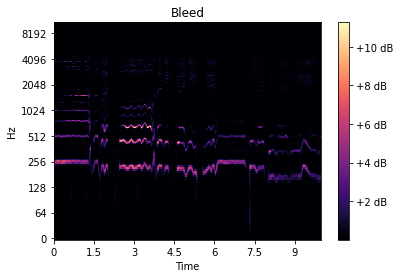

In [91]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_v), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Bleed')
fig.colorbar(img, ax=ax, format="%+2.f dB")

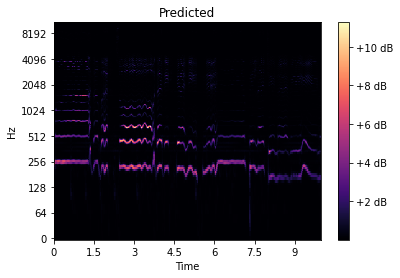

In [92]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_vp), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Predicted')
fig.colorbar(img, ax=ax, format="%+2.f dB")

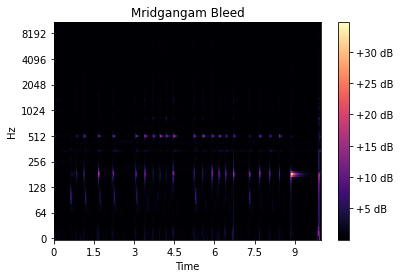

In [93]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_mr), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Mridgangam Bleed')
fig.colorbar(img, ax=ax, format="%+2.f dB")

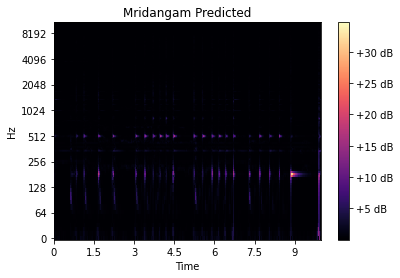

In [94]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_mrp), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Mridangam Predicted')
fig.colorbar(img, ax=ax, format="%+2.f dB")

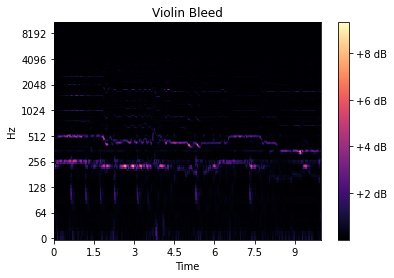

In [95]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_vi), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Violin Bleed')
fig.colorbar(img, ax=ax, format="%+2.f dB")

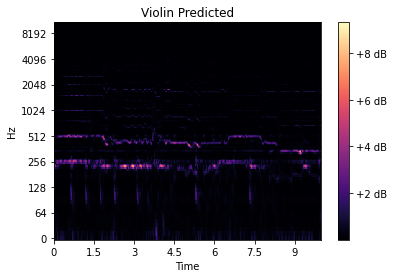

In [96]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_vip), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Violin Predicted')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [97]:
np.mean(A_pred, axis=0)

array([[1.e+00, 1.e-05, 1.e-05],
       [1.e-05, 1.e+00, 1.e-05],
       [1.e-05, 1.e-05, 1.e+00]])

# SDR, SPECT< LAMBDA CALCULATION OF KAMIR

In [276]:
name = 'Leaf - Wicked/'
path = ''+name
p = "/home/rajesh/Desktop/EXPERIMENT RESULTS/KAMIR/"
clean_path = "/home/rajesh/Desktop/Datasets/musdb18hq/train/"+name
i = name

In [277]:
b1 = fs*60
b2 = int(fs*10+b1)

In [278]:
bv, fs = lb.load(p+i+'/vocal.wav')
bb, fs = lb.load(p+i+'/bass.wav')
bd, fs = lb.load(p+i+'/drums.wav')
bo, fs = lb.load(p+i+'/others.wav')

tv, fs = lb.load(clean_path+'/vocals.wav')
tb, fs = lb.load(clean_path+'/bass.wav')
td, fs = lb.load(clean_path+'/drums.wav')
to, fs = lb.load(clean_path+'/other.wav')

tv = tv[b1:b2]
tb = tb[b1:b2]
td = td[b1:b2]
to = to[b1:b2]

pv, fs = lb.load(p+i+'/vocal_pred.wav')
pb, fs = lb.load(p+i+'/bass_pred.wav')
pd, fs = lb.load(p+i+'/drums_pred.wav')
po, fs = lb.load(p+i+'/others_pred.wav')

In [279]:
v_sdr = compute_sdr(tv, pv, fs)
b_sdr = compute_sdr(tb, pb, fs)
d_sdr = compute_sdr(td, pd, fs)
o_sdr = compute_sdr(to, po, fs)

sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
sdr, v_sdr, b_sdr, d_sdr, o_sdr

(12.881913881016546,
 16.028062291766684,
 13.931787180672046,
 9.782318556560927,
 11.785487495066528)

In [280]:
X = np.array([bv, bb, bd, bo])
S = np.array([pv, pb, pd, po])

In [281]:
A_pred = X @ np.linalg.pinv(S)
A_pred

array([[1.0026369 , 0.1022484 , 0.10090989, 0.09546001],
       [0.10068881, 1.0123042 , 0.10276599, 0.1109973 ],
       [0.10904598, 0.1276256 , 1.0258737 , 0.12105799],
       [0.10659603, 0.10019246, 0.09808321, 1.0427738 ]], dtype=float32)

In [282]:
X_true = np.array([tv, tb, td, to])
A_true = X_true @ np.linalg.pinv(S)
A_true

array([[ 1.0013068e+00, -1.1258693e-03, -1.3500577e-03, -1.1054630e-02],
       [-8.5574947e-04,  1.0100486e+00,  7.1069424e-04,  6.2091355e-03],
       [ 8.4287059e-03,  2.7073257e-02,  1.0263865e+00,  1.7388063e-02],
       [ 5.7066181e-03, -3.4090097e-03, -4.4909837e-03,  1.0415159e+00]],
      dtype=float32)

In [283]:
np.linalg.norm(A_true-A_pred)**2

0.12662002529843708

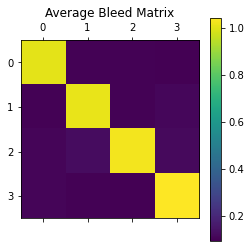

In [284]:
import numpy as np
import matplotlib.pyplot as plt

plt.matshow(A_pred)
plt.colorbar()
plt.title('Average Bleed Matrix')
plt.show()

In [285]:
bvstft = lb.stft(bv)

pvstft = lb.stft(pv)

vstft = lb.stft(tv)

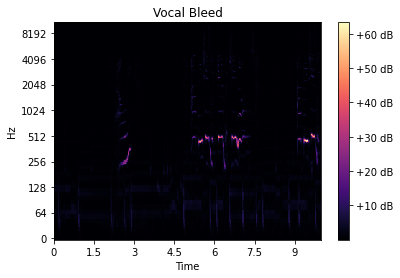

In [286]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(bvstft), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Vocal Bleed')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(p+i+'VocalBleedSpect.png')

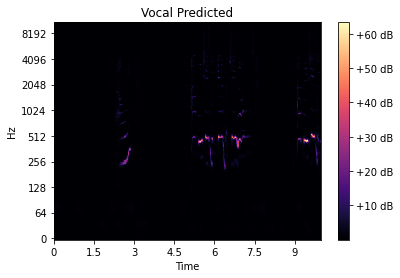

In [287]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(pvstft), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Vocal Predicted')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(p+i+'VocalPredSpect.png')

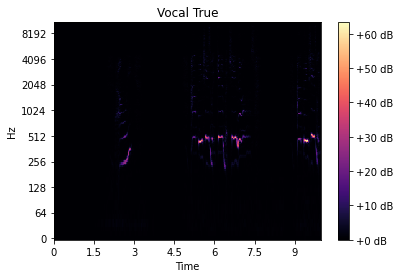

In [288]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(vstft), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Vocal True')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(p+i+'VocalTrueSpect.png')